# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(train['features'])

# TODO: Number of testing examples.
n_test = len(test['features'])

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

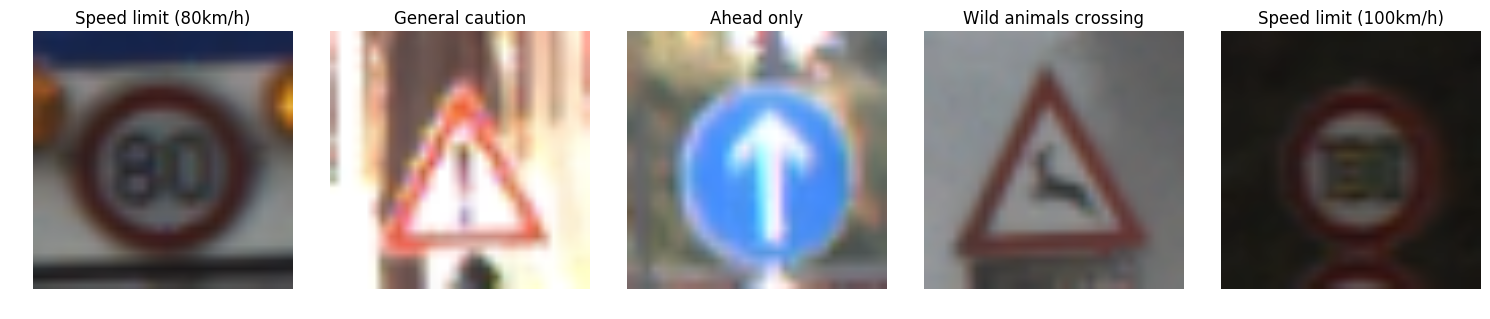

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

sign_names = pd.read_csv('signnames.csv')

# Show 5 random train images with label
pos = np.random.randint(0, len(X_train), 5)
images = X_train[pos]
labels = y_train[pos]

plt.rcParams["figure.figsize"] = [15, 5]

for i, image in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.axis("off")  # clear x- and y-axes
    plt.imshow(image)
    plt.title(sign_names.iloc[labels[i]]['SignName'])
    
plt.tight_layout()

<Container object of 43 artists>

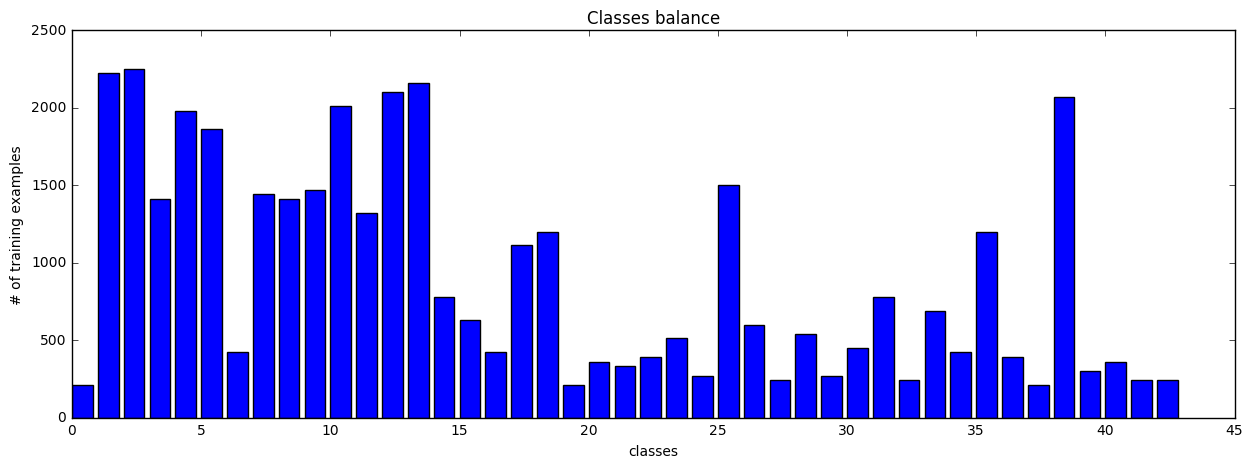

In [4]:
# Show distribution of classes to evaluate if classes are balanced
y = np.bincount(y_train)

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

N = len(y)
x = range(N)
ax.set_ylabel('# of training examples')
ax.set_xlabel('classes')
ax.set_title('Classes balance')

ax.bar(x, y)

* The classes are clearly imbalanced: one important consequence is the poor classification rates in minority classes, while majority classes tend to be accurately recognized. A simple and quick approach would be to apply random oversampling.

* Some images are very dark, therefore preprocessing the images and equalize the contrast could probably bring to better results

* Images are already 32x32x3, so they can be used in a LeNet-5 architecture.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# apply OpenCV CLAHE (Contrast Limited Adaptive Histogram Equalization) to train and test images

import cv2

def applyClahe(img):
    # Converting image to LAB Color model
    lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # Splitting the LAB image to different channels
    l, a, b = cv2.split(lab)
    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(2,2))
    cl = clahe.apply(l)
    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    # Converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

for i in range(len(X_train)):
    X_train[i] = applyClahe(X_train[i])
    
for i in range(len(X_test)):
    X_test[i] = applyClahe(X_test[i])
    
print('CLAHE preprocessing completed')





CLAHE preprocessing completed


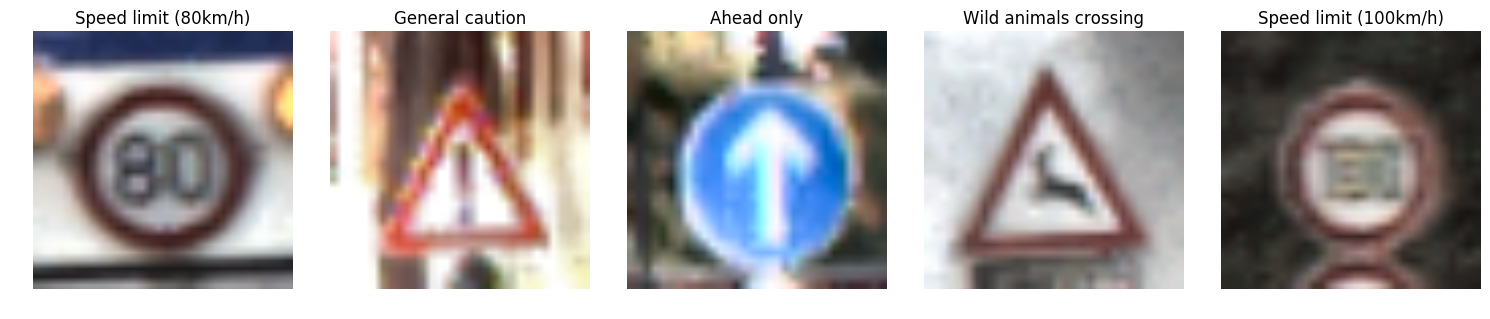

In [6]:
# Show the same 5 random images to evaluate the improvement introduced by CLAHE preprocessing
images = X_train[pos]
labels = y_train[pos]

plt.rcParams["figure.figsize"] = [15, 5]

for i, image in enumerate(images):
    plt.subplot(1, 5, i+1)
    plt.axis("off")  # clear x- and y-axes
    plt.imshow(image)
    plt.title(sign_names.iloc[labels[i]]['SignName'])
    
plt.tight_layout()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

* I noticed that a lot of images were very dark, therefore I decided to improve the contrast automatically, using OpenCV's CLAHE (Contrast Limited Adaptive Histogram Equalization). I preferred to not remove color information (i.e. transform to grayscale), therefore I had to apply CLAHE to the three channels separately and then merge the results.


<Container object of 43 artists>

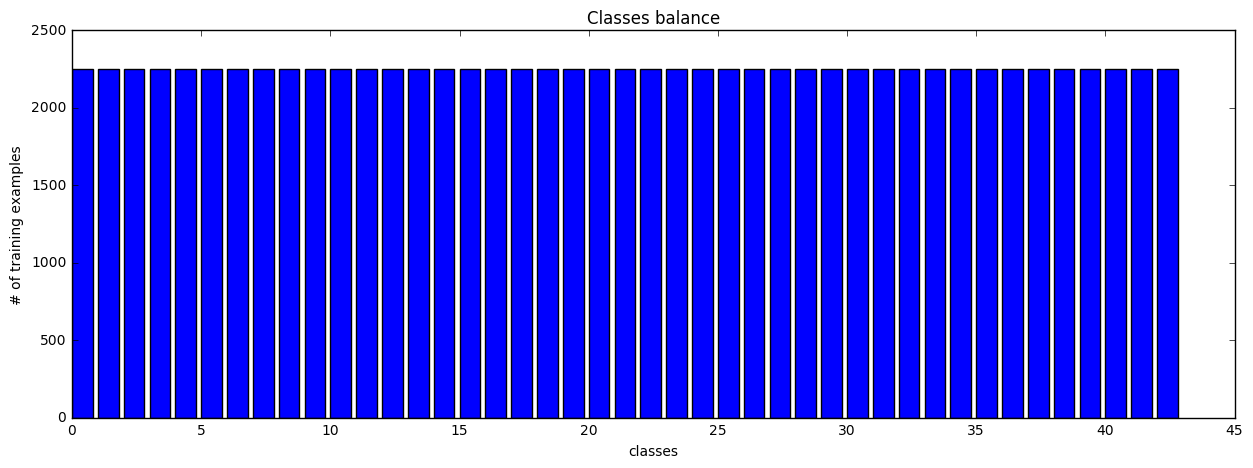

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# generate additional data in minority classes with RandomOverSampler

from imblearn.over_sampling import RandomOverSampler

ybin = np.bincount(y_train)

# Apply RandomOverSampler
sm = RandomOverSampler(random_state=0)
X_resampled, y_resampled = sm.fit_sample(X_train.flatten().reshape( (len(X_train), 3072) ) , y_train) # 32 * 32 * 3


# reshape X_train to 32x32x3 images
X_resampled = X_resampled.reshape( (len(X_resampled), 32, 32, 3))

ybin = np.bincount(y_resampled)

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

N = len(ybin)
x = range(N)
ax.set_ylabel('# of training examples')
ax.set_xlabel('classes')
ax.set_title('Classes balance')

ax.bar(x, ybin)


In [8]:
# split the data into training/validation/testing sets
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 256

# split training/validation/test (with randomization)
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
   X_resampled,
   y_resampled,
   test_size=0.2,
   random_state=100
)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

* additional data have been generated using imblearn.over_sampling.RandomOverSampler. This step only replicated observations in the minority classes to obtain the same number of observations found in the majority class. The reason I did that, is to avoid overfitting to the majority classes. Another potential approach would have been to use SMOTE or to generate additional observations with small modifications (e.g. rotation, brightness, etc)
* training and validations sets have been created using the train_test_split method in sklearn.model_selection (0.8, 0.2)

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I used a LeNet-5 architecture:

* Layer 1: Convolutional. The output shape is 28x28x6.
* Activation: ReLU.
* Pooling. The output shape is 14x14x6.
* Layer 2: Convolutional. The output shape is 10x10x16.
* Activation: ReLU.
* Pooling. The output shape is 5x5x16.
* Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D
* Layer 3: Fully Connected. This has 120 outputs.
* Activation: ReLU.
* Layer 4: Fully Connected. This has 84 outputs.
* Activation: ReLU.
* Layer 5: Fully Connected (Logits). This has 43 outputs.

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle

# features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# training pipeline
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# train the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        if (i<9 or i>41):
            print("EPOCH {} ...".format(i+1) + " - validation Accuracy = {:.3f}".format(validation_accuracy))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'traffic_signs')
    print("Model saved")
    



Training...

EPOCH 1 ... - validation Accuracy = 0.842
EPOCH 2 ... - validation Accuracy = 0.938
EPOCH 3 ... - validation Accuracy = 0.960
EPOCH 4 ... - validation Accuracy = 0.968
EPOCH 5 ... - validation Accuracy = 0.977
EPOCH 6 ... - validation Accuracy = 0.966
EPOCH 7 ... - validation Accuracy = 0.980
EPOCH 8 ... - validation Accuracy = 0.983
EPOCH 9 ... - validation Accuracy = 0.987
EPOCH 43 ... - validation Accuracy = 0.992
EPOCH 44 ... - validation Accuracy = 0.995
EPOCH 45 ... - validation Accuracy = 0.994
EPOCH 46 ... - validation Accuracy = 0.992
EPOCH 47 ... - validation Accuracy = 0.991
EPOCH 48 ... - validation Accuracy = 0.984
EPOCH 49 ... - validation Accuracy = 0.995
EPOCH 50 ... - validation Accuracy = 0.992
Model saved


In [11]:
# evaluate the model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic_signs.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.913


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Type of optimizer: AdamOptimizer
* Batch size: 256
* Number of epochs: 50
* Learning rate: 0.001
* Split training/validation: 80% - 20%

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

* I started from a well known implementation (LeNet-5) that we already saw during the course. As we used that architecture to recognize MNIST digits, I thought it could be used as well for traffic sign classification
* I tried different combinations of batch size and number of epochs to reach an acceptable accuracy (about 90%) on the test set

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

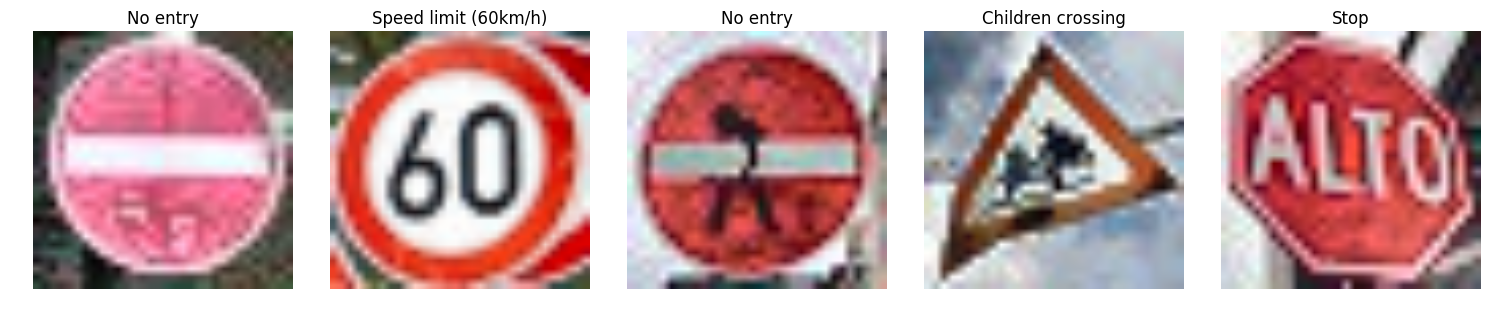

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as img
import matplotlib.pyplot as plt

%matplotlib inline

X_my_test = []

y_my_test = [17, 3, 17, 28, 14]

for i in range(1,6):
    image = img.imread(str(i) + '.jpg')
    X_my_test.append(applyClahe(image))
    
plt.rcParams["figure.figsize"] = [15, 5]

for i, image in enumerate(X_my_test):
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.title(sign_names.iloc[y_my_test[i]]['SignName'])
    plt.imshow(image)
    
plt.tight_layout()
    


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

* Image 2: the image is a bit skewed and there are other signs in the background
* Image 3: the no-entry sign has been modified with a sticker
* Image 4: sign is damaged and seen from a different point of view
* Image 5: stop sign is in a different language

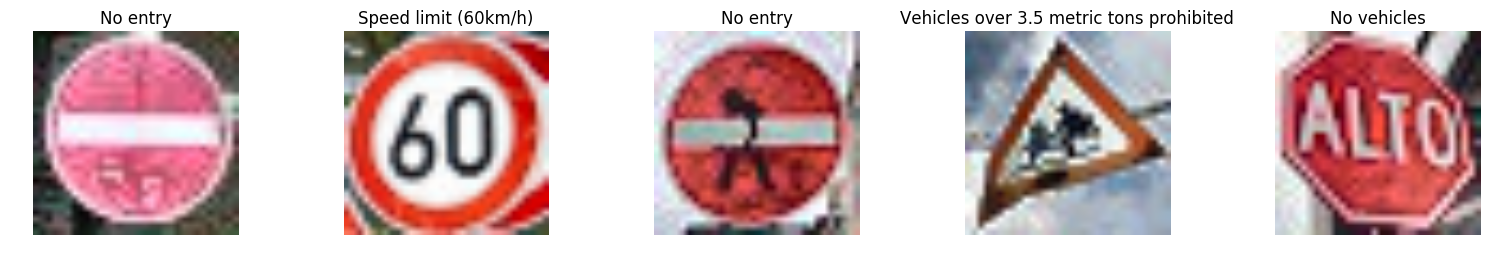

In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic_signs.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    pred = sess.run(prediction, feed_dict={x: X_my_test, y: y_my_test})
    
    plt.rcParams["figure.figsize"] = [15, 5]

    for i, image in enumerate(X_my_test):
        plt.subplot(1, 5, i+1)
        plt.axis("off")
        plt.title(sign_names.iloc[pred[i]]['SignName'])
        plt.imshow(image)

    plt.tight_layout()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

* Accuracy on new signs is 60% (first 3 images have been classified correctly)
* Accuracy on the test set is 0.898, definitely higher than the accuracy on the 5 signs set
* Reasons for this difference can be many: one of the most important is that one of the signs I found was not even a valid German traffic sign and another one was very deformed

In [26]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

softmax = tf.nn.softmax(logits)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('traffic_signs.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    probability = sess.run(softmax, feed_dict={x: X_my_test, y: y_my_test})
    prob = np.squeeze(probability[0:5])
    topk = sess.run(tf.nn.top_k(tf.constant(prob), k=3))
    # print correct label and largest 3 probabilities
    i = 0
    for label in y_my_test:
        print('Correct label: ',sign_names.iloc[label]['SignName'])
        j = 0
        for match in topk[1][i]:
            print('Best match: ', sign_names.iloc[match]['SignName'], ' : ', topk[0][i][j])
            j += 1
        i+=1
        print()
 

Correct label:  No entry
Best match:  No entry  :  1.0
Best match:  Yield  :  2.47829e-34
Best match:  Speed limit (20km/h)  :  0.0

Correct label:  Speed limit (60km/h)
Best match:  Speed limit (60km/h)  :  0.983199
Best match:  Go straight or right  :  0.0145654
Best match:  Keep right  :  0.00223549

Correct label:  No entry
Best match:  No entry  :  1.0
Best match:  Speed limit (20km/h)  :  0.0
Best match:  Speed limit (30km/h)  :  0.0

Correct label:  Children crossing
Best match:  Vehicles over 3.5 metric tons prohibited  :  1.0
Best match:  Speed limit (20km/h)  :  7.23299e-24
Best match:  Speed limit (120km/h)  :  1.33649e-29

Correct label:  Stop
Best match:  No vehicles  :  0.582035
Best match:  Traffic signals  :  0.412562
Best match:  Bicycles crossing  :  0.00535341



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

* Which predictions is the model certain of? Images 1, 2, 3, 4 (even though classification of image 4 is wrong)
* Uncertain? Image 5. Second highest probability is the one for "Priority road"
* If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? Not in the top 3: the last two images were quite difficult to classify correctly

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.